# LSTM-Based Anomaly Detection for CTA Trains

This notebook demonstrates training an LSTM model for sequence-based anomaly detection using PyTorch Lightning.

In [1]:
import sys
import os
sys.path.append('../..')

import torch
import pytorch_lightning as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.models.lstm_anomaly import CTALSTMTrainer, LSTMAnomalyDetector
from src.api.lstm_predictor import LSTMPredictor

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Load and Explore Data

In [2]:
# Initialize trainer
trainer = CTALSTMTrainer(db_path='../../data/cta_database.db')

# Load data
df = trainer.load_data(limit=5000)  # Limit for faster training in demo

print(f"Loaded {len(df)} records")
print(f"Anomaly rate: {df['is_anomaly'].mean():.2%}")
print(f"Unique trains: {df['run_number'].nunique()}")

df.head()

Loaded 5000 records
Anomaly rate: 27.82%
Unique trains: 84


,fetch_timestamp,run_number,route_name,latitude,longitude,heading,is_delayed,speed_kmh,hour_of_day,day_of_week,is_anomaly
0,1756805121,001,g,41.83168,-87.62588,178,0,0.0,9,1,1
1,1756805179,001,g,41.83168,-87.62588,178,0,0.0,9,1,1
2,1756805181,001,g,41.83168,-87.62588,178,0,0.0,9,1,1
3,1756805237,001,g,41.83168,-87.62588,178,0,0.0,9,1,1
4,1756805240,001,g,41.83168,-87.62588,178,0,0.0,9,1,1


## 2. Visualize Sequence Data

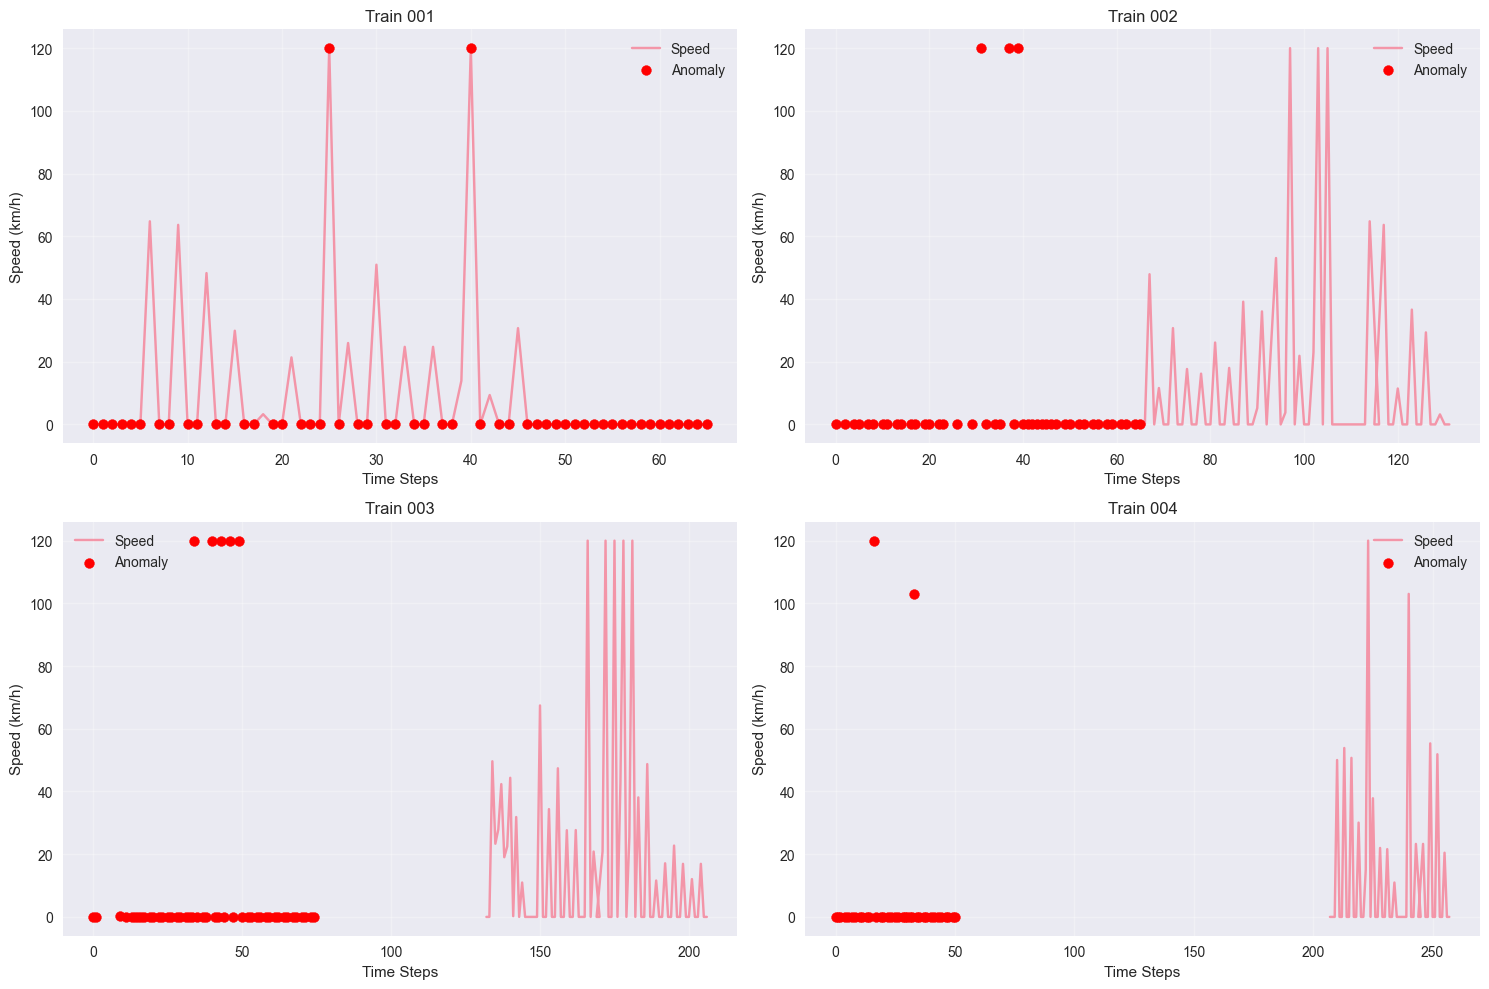

In [3]:
# Plot speed patterns for a few trains
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

sample_trains = df['run_number'].unique()[:4]

for i, train_id in enumerate(sample_trains):
    train_data = df[df['run_number'] == train_id].sort_values('fetch_timestamp')
    
    axes[i].plot(train_data['speed_kmh'], label='Speed', alpha=0.7)
    
    # Highlight anomalies
    anomalies = train_data[train_data['is_anomaly'] == 1]
    if len(anomalies) > 0:
        axes[i].scatter(anomalies.index - train_data.index[0], 
                       anomalies['speed_kmh'], 
                       color='red', s=50, label='Anomaly', zorder=5)
    
    axes[i].set_title(f'Train {train_id}')
    axes[i].set_xlabel('Time Steps')
    axes[i].set_ylabel('Speed (km/h)')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Train LSTM Model

In [ ]:
# Train the model
print("🔥 Training LSTM model...")

model = trainer.train(
    sequence_length=10,
    batch_size=32,
    max_epochs=20,  # Reduced for demo
    val_split=0.2
)

print("✅ Training completed!")

🔥 Training LSTM model...


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


## 4. Save and Test Model

In [ ]:
# Save the model
model_path = '../../models/lstm_anomaly_model.ckpt'
os.makedirs(os.path.dirname(model_path), exist_ok=True)
trainer.save_model(model_path)

print(f"Model saved to {model_path}")

## 5. Test Predictions

In [ ]:
# Test the predictor
predictor = LSTMPredictor(model_path=model_path)
predictor.load_model()

# Test with sample data
test_data = {
    'train_id': 'test_train',
    'speed_kmh': 85.0,  # High speed - should be anomalous
    'latitude': 41.8781,
    'longitude': -87.6298,
    'heading': 180,
    'hour_of_day': 14,
    'day_of_week': 1,
    'is_delayed': 0
}

# This will use fallback since we don't have history for 'test_train'
result = predictor.predict_from_current_data(test_data)

print("Prediction Result:")
for key, value in result.items():
    print(f"  {key}: {value}")

## 6. Model Performance Analysis

In [ ]:
# Analyze model architecture
print("Model Architecture:")
print(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

## 7. Next Steps

1. **Integration**: Integrate with the existing API using `HybridPredictor`
2. **Hyperparameter Tuning**: Experiment with different architectures
3. **Conformal Prediction**: Add uncertainty quantification
4. **Real-time Testing**: Test with live CTA data
5. **Performance Monitoring**: Track model performance over time